# Multi-head Attention

![Screenshot 2025-09-08 at 19.35.41.png](<attachment:Screenshot 2025-09-08 at 19.35.41.png>)
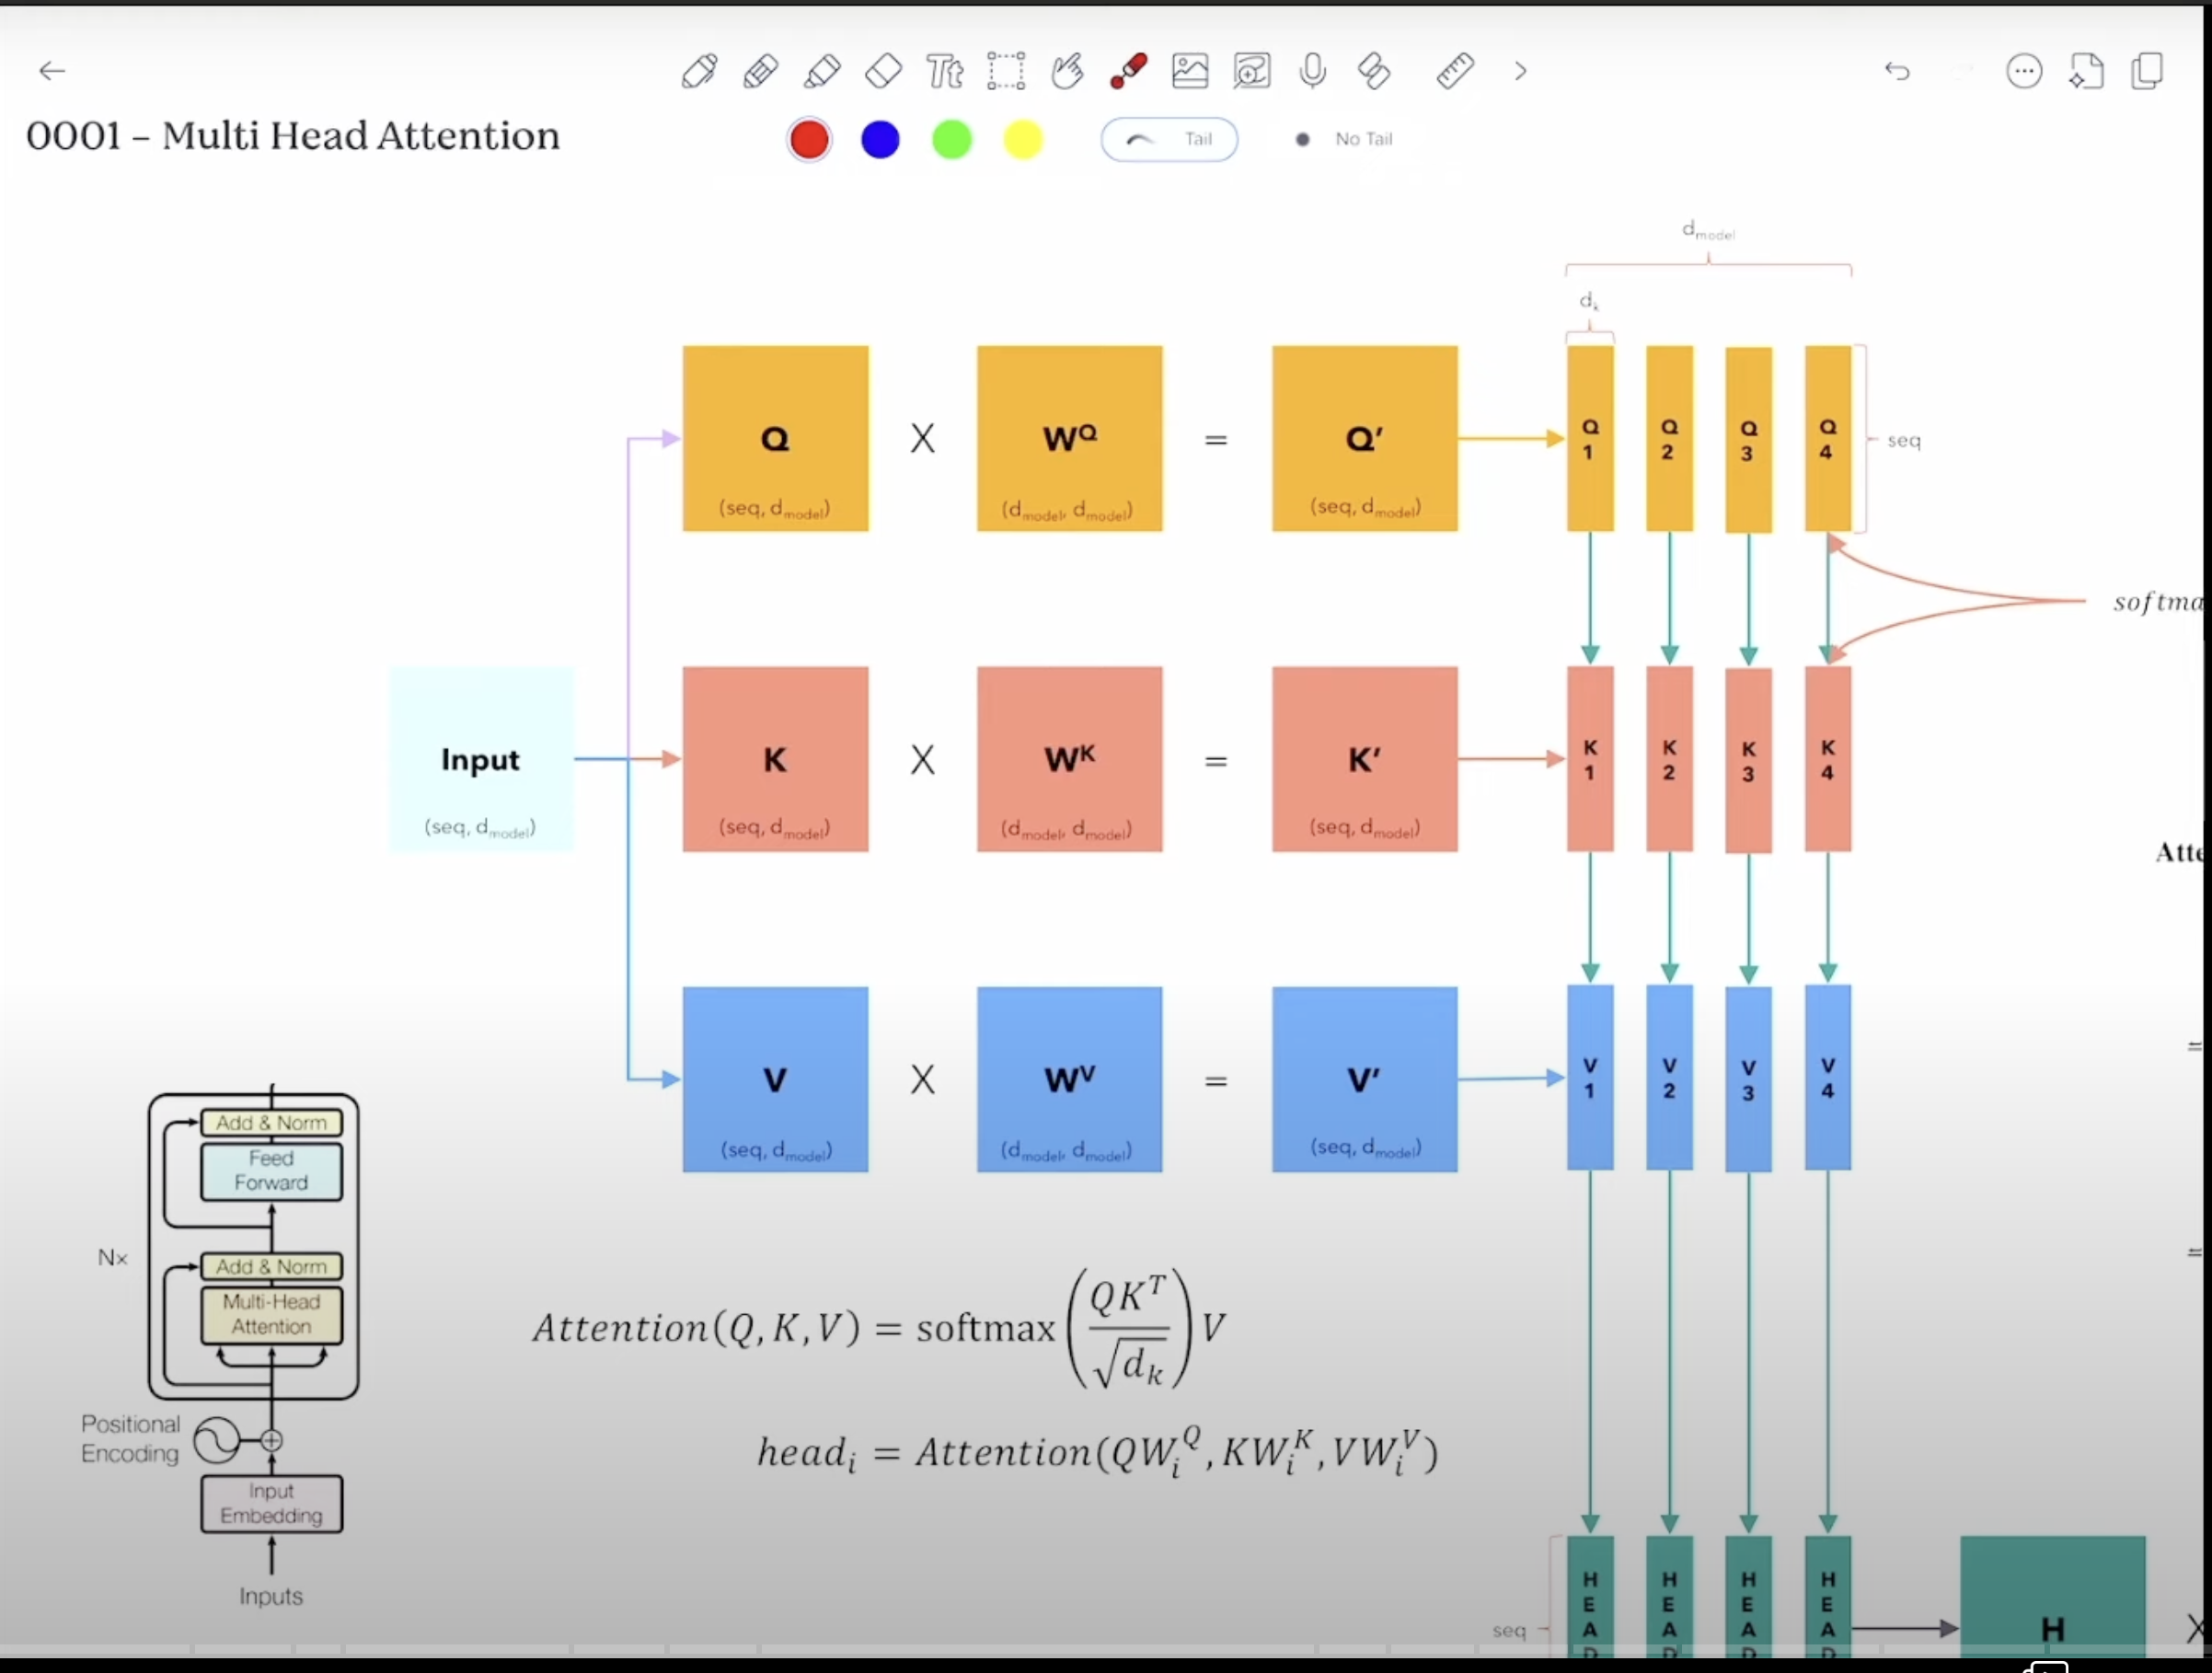

#### MHA starts with single input sequence or two input sequence  in regard to cross head attention

-------------------------------------------------------------------
When we talk about **multi-head attention**, we’re dealing with two main contexts:

1. **Self-Attention**

   * This starts with a **single input sequence** (for example, a sentence: *“The cat sat on the mat”*).
   * The same sequence is used to generate **queries (Q), keys (K), and values (V)**.
   * Each token (like *“cat”*) attends to all other tokens in that same sequence.
   * Example: in *“The cat sat”*, the word *“cat”* might pay more attention to *“sat”* than *“the”*.

2. **Cross-Attention**

   * This involves **two input sequences**.
   * Common in encoder-decoder architectures (like in Transformers for translation).
   * One sequence (say, from the encoder = source sentence in French) provides the **keys (K) and values (V)**.
   * The other sequence (say, from the decoder = English being generated) provides the **queries (Q)**.
   * This allows the decoder to “look at” the encoder’s sequence while generating output.

---

### So in short:

* **Self-attention (single sequence):** Q, K, V all come from the **same sequence**.
* **Cross-attention (two sequences):** Q comes from the **decoder sequence**, while K and V come from the **encoder sequence**.

And **multi-head** just means we do this in parallel with multiple sets of Q/K/V projections, so the model can capture different types of relationships (e.g., syntax, semantics, long-distance dependencies).


-------------------------------------------------------------------------

#### our input seq is (seq, d_model) : where seq is number of sequences/tokens and each seq is represeneted by an embedding vector with d_model  dimensions 

-------------------------------------------------------------------------

Exactly ✅ you’ve got the shape right. Let’s unpack this carefully with respect to **multi-head attention**.

---

### Input Representation

* You start with a batch of tokens (let’s ignore batch size for now).
* The input tensor is:

$$
X \in \mathbb{R}^{(\text{seq\_len}, d_\text{model})}
$$

where:

* **seq\_len** = number of tokens in the sequence
* **d\_model** = embedding dimension (e.g., 512 or 768 in Transformers)

So each token is a row vector of size $d_\text{model}$.

---

### In **Self-Attention**

We project the same input $X$ three different ways to get **Q, K, V**:

$$
Q = XW_Q, \quad K = XW_K, \quad V = XW_V
$$

where $W_Q, W_K, W_V \in \mathbb{R}^{d_\text{model} \times d_k}$.

* So all queries, keys, and values are derived from the **same sequence**.
* Shapes:

  * $Q, K, V \in \mathbb{R}^{(\text{seq\_len}, d_k)}$

Then attention is computed as:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

---

### In **Cross-Attention**

We have **two sequences**:

* Decoder input (say, partially generated English translation): $X_{dec} \in \mathbb{R}^{(\text{seq\_len}^{dec}, d_\text{model})}$
* Encoder output (say, processed French sentence): $X_{enc} \in \mathbb{R}^{(\text{seq\_len}^{enc}, d_\text{model})}$

We then project them differently:

$$
Q = X_{dec}W_Q, \quad K = X_{enc}W_K, \quad V = X_{enc}W_V
$$

* Queries come from the **decoder sequence**.
* Keys & values come from the **encoder sequence**.
* Shapes:

  * $Q \in \mathbb{R}^{(\text{seq\_len}^{dec}, d_k)}$
  * $K, V \in \mathbb{R}^{(\text{seq\_len}^{enc}, d_k)}$

This way, the decoder tokens can attend to the entire encoder sequence.

---

### Multi-Head Part

Instead of doing this once, we split $d_\text{model}$ into multiple “heads”:

* Suppose $d_\text{model} = 512$, number of heads = 8.
* Then each head works with $d_k = d_v = 64$.
* We compute attention **in parallel** for each head and then concatenate results:

$$
\text{MultiHead}(Q,K,V) = \text{Concat}(head_1, \ldots, head_h)W_O
$$

---

👉 So your intuition was correct:

* **Shape starts as (seq\_len, d\_model)**.
* In **self-attention**, Q, K, V all come from the same input.
* In **cross-attention**, Q comes from one sequence (decoder), while K and V come from another (encoder).




#### W_q, W_k and W_v are all represented by linear layers  and these layers are (d_model, d_model), so they dont change the shape of input tensor 


![Screenshot 2025-09-08 at 22.58.55.png](<attachment:Screenshot 2025-09-08 at 22.58.55.png>)

in practice, **$W_Q$, $W_K$, $W_V$ are implemented as linear (dense) layers with weight matrices of shape**

$$
(d_\text{model}, d_\text{model})
$$

That means if your input tensor is

$$
X \in \mathbb{R}^{(\text{seq\_len}, d_\text{model})}
$$

then

$$
Q = XW_Q, \quad K = XW_K, \quad V = XW_V
$$

all have **the same shape**:

$$
Q, K, V \in \mathbb{R}^{(\text{seq\_len}, d_\text{model})}
$$

---

### But where does $d_k$ and $d_v$ come in then?

That happens when we **split into heads**.

* Let’s say:

  * $d_\text{model} = 512$
  * Number of heads $h = 8$
  * Then each head works on subspaces of size:

  $$
  d_k = d_v = \frac{d_\text{model}}{h} = 64
  $$

* After computing $Q, K, V \in (\text{seq\_len}, d_\text{model})$,
  we **reshape** them into

  $$
  (\text{seq\_len}, h, d_k)
  $$

* Attention is computed **per head** on the $d_k$-dimensional slices.

---

### Workflow Recap

1. Input:

   $$
   X \in (\text{seq\_len}, d_\text{model})
   $$

2. Linear projections (no shape change):

   $$
   Q, K, V \in (\text{seq\_len}, d_\text{model})
   $$

3. Reshape/split into heads:

   $$
   Q, K, V \in (\text{seq\_len}, h, d_k), \quad d_k = d_\text{model}/h
   $$

4. Scaled dot-product attention per head:

   $$
   \text{Attention}_i(Q,K,V) \in (\text{seq\_len}, d_v), \quad d_v = d_k
   $$

5. Concatenate across heads:

   $$
   \text{Concat}(head_1,\dots,head_h) \in (\text{seq\_len}, d_\text{model})
   $$

6. Final linear projection $W_O \in (d_\text{model}, d_\text{model})$ to mix head outputs.

---

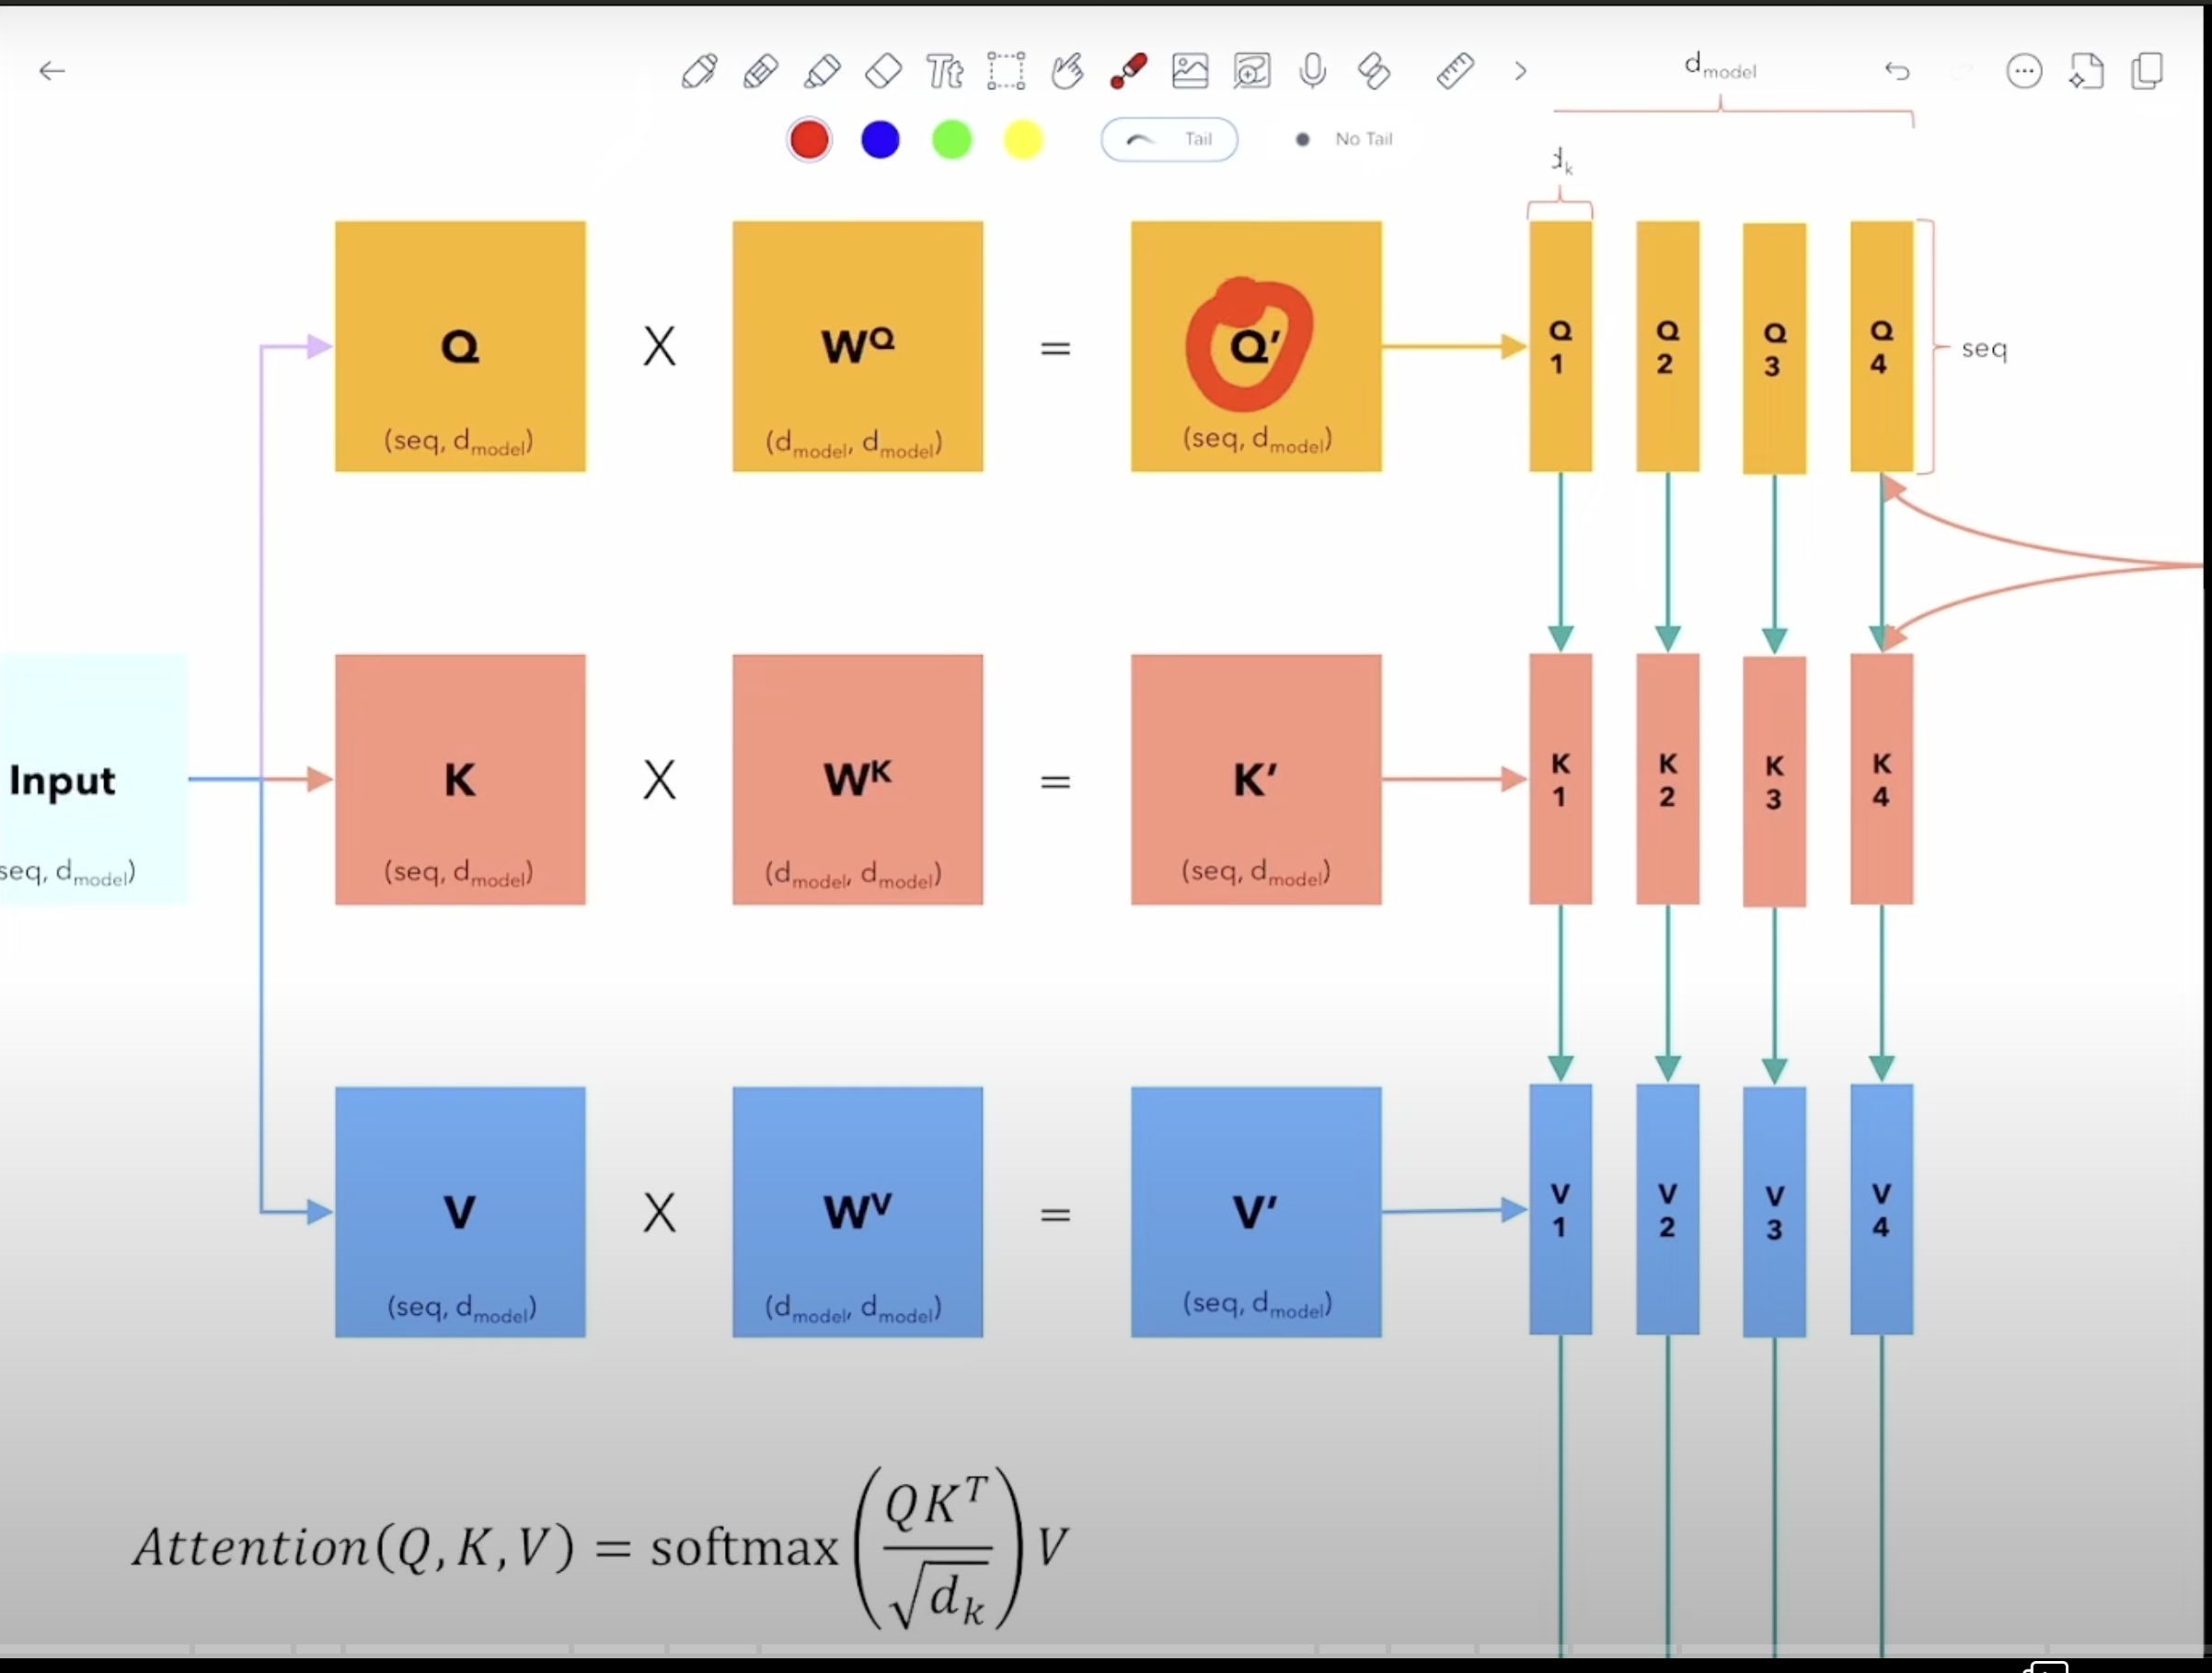

#### then we divide Q`, K` and V` in smaller embeddings 

![Screenshot 2025-09-08 at 23.03.27.png](<attachment:Screenshot 2025-09-08 at 23.03.27.png>)


----------------------------------------------------------------------------
### Step 1 — Start with projections

We project the input with $W_Q, W_K, W_V$, each of size $(d_\text{model}, d_\text{model})$:

$$
Q', K', V' \in \mathbb{R}^{(\text{seq\_len}, d_\text{model})}
$$

At this point, they still have the **same dimension** as the input.

---

### Step 2 — Split into heads

Now, let’s assume:

* $d_\text{model} = 512$
* Number of heads $h = 8$
* Then each head gets:

$$
d_k = d_v = \frac{d_\text{model}}{h} = 64
$$

We reshape:

$$
Q', K', V' \;\; \to \;\; ( \text{seq\_len}, h, d_k )
$$

So for each token, instead of one $512$-dim vector, you now have **8 parallel 64-dim sub-vectors** — one per head.

---

### Step 3 — Attention per head

For each head $i$:

$$
\text{Attention}_i(Q_i, K_i, V_i) = \text{softmax}\!\left(\frac{Q_i K_i^T}{\sqrt{d_k}}\right) V_i
$$

Output shape per head:

$$
(\text{seq\_len}, d_v)
$$

---

### Step 4 — Concatenate heads

We concatenate all head outputs back together:

$$
\text{Concat}(head_1, \dots, head_h) \in (\text{seq\_len}, d_\text{model})
$$

---

### Step 5 — Final linear layer

A last linear projection $W_O \in (d_\text{model}, d_\text{model})$ mixes the head information.

---

So when you say:

> “then we divide Q’, K’, V’ in smaller embeddings”

that is **precisely the reshaping into $(seq\_len, h, d_k)$**, where each smaller embedding is what each attention head works on.

---

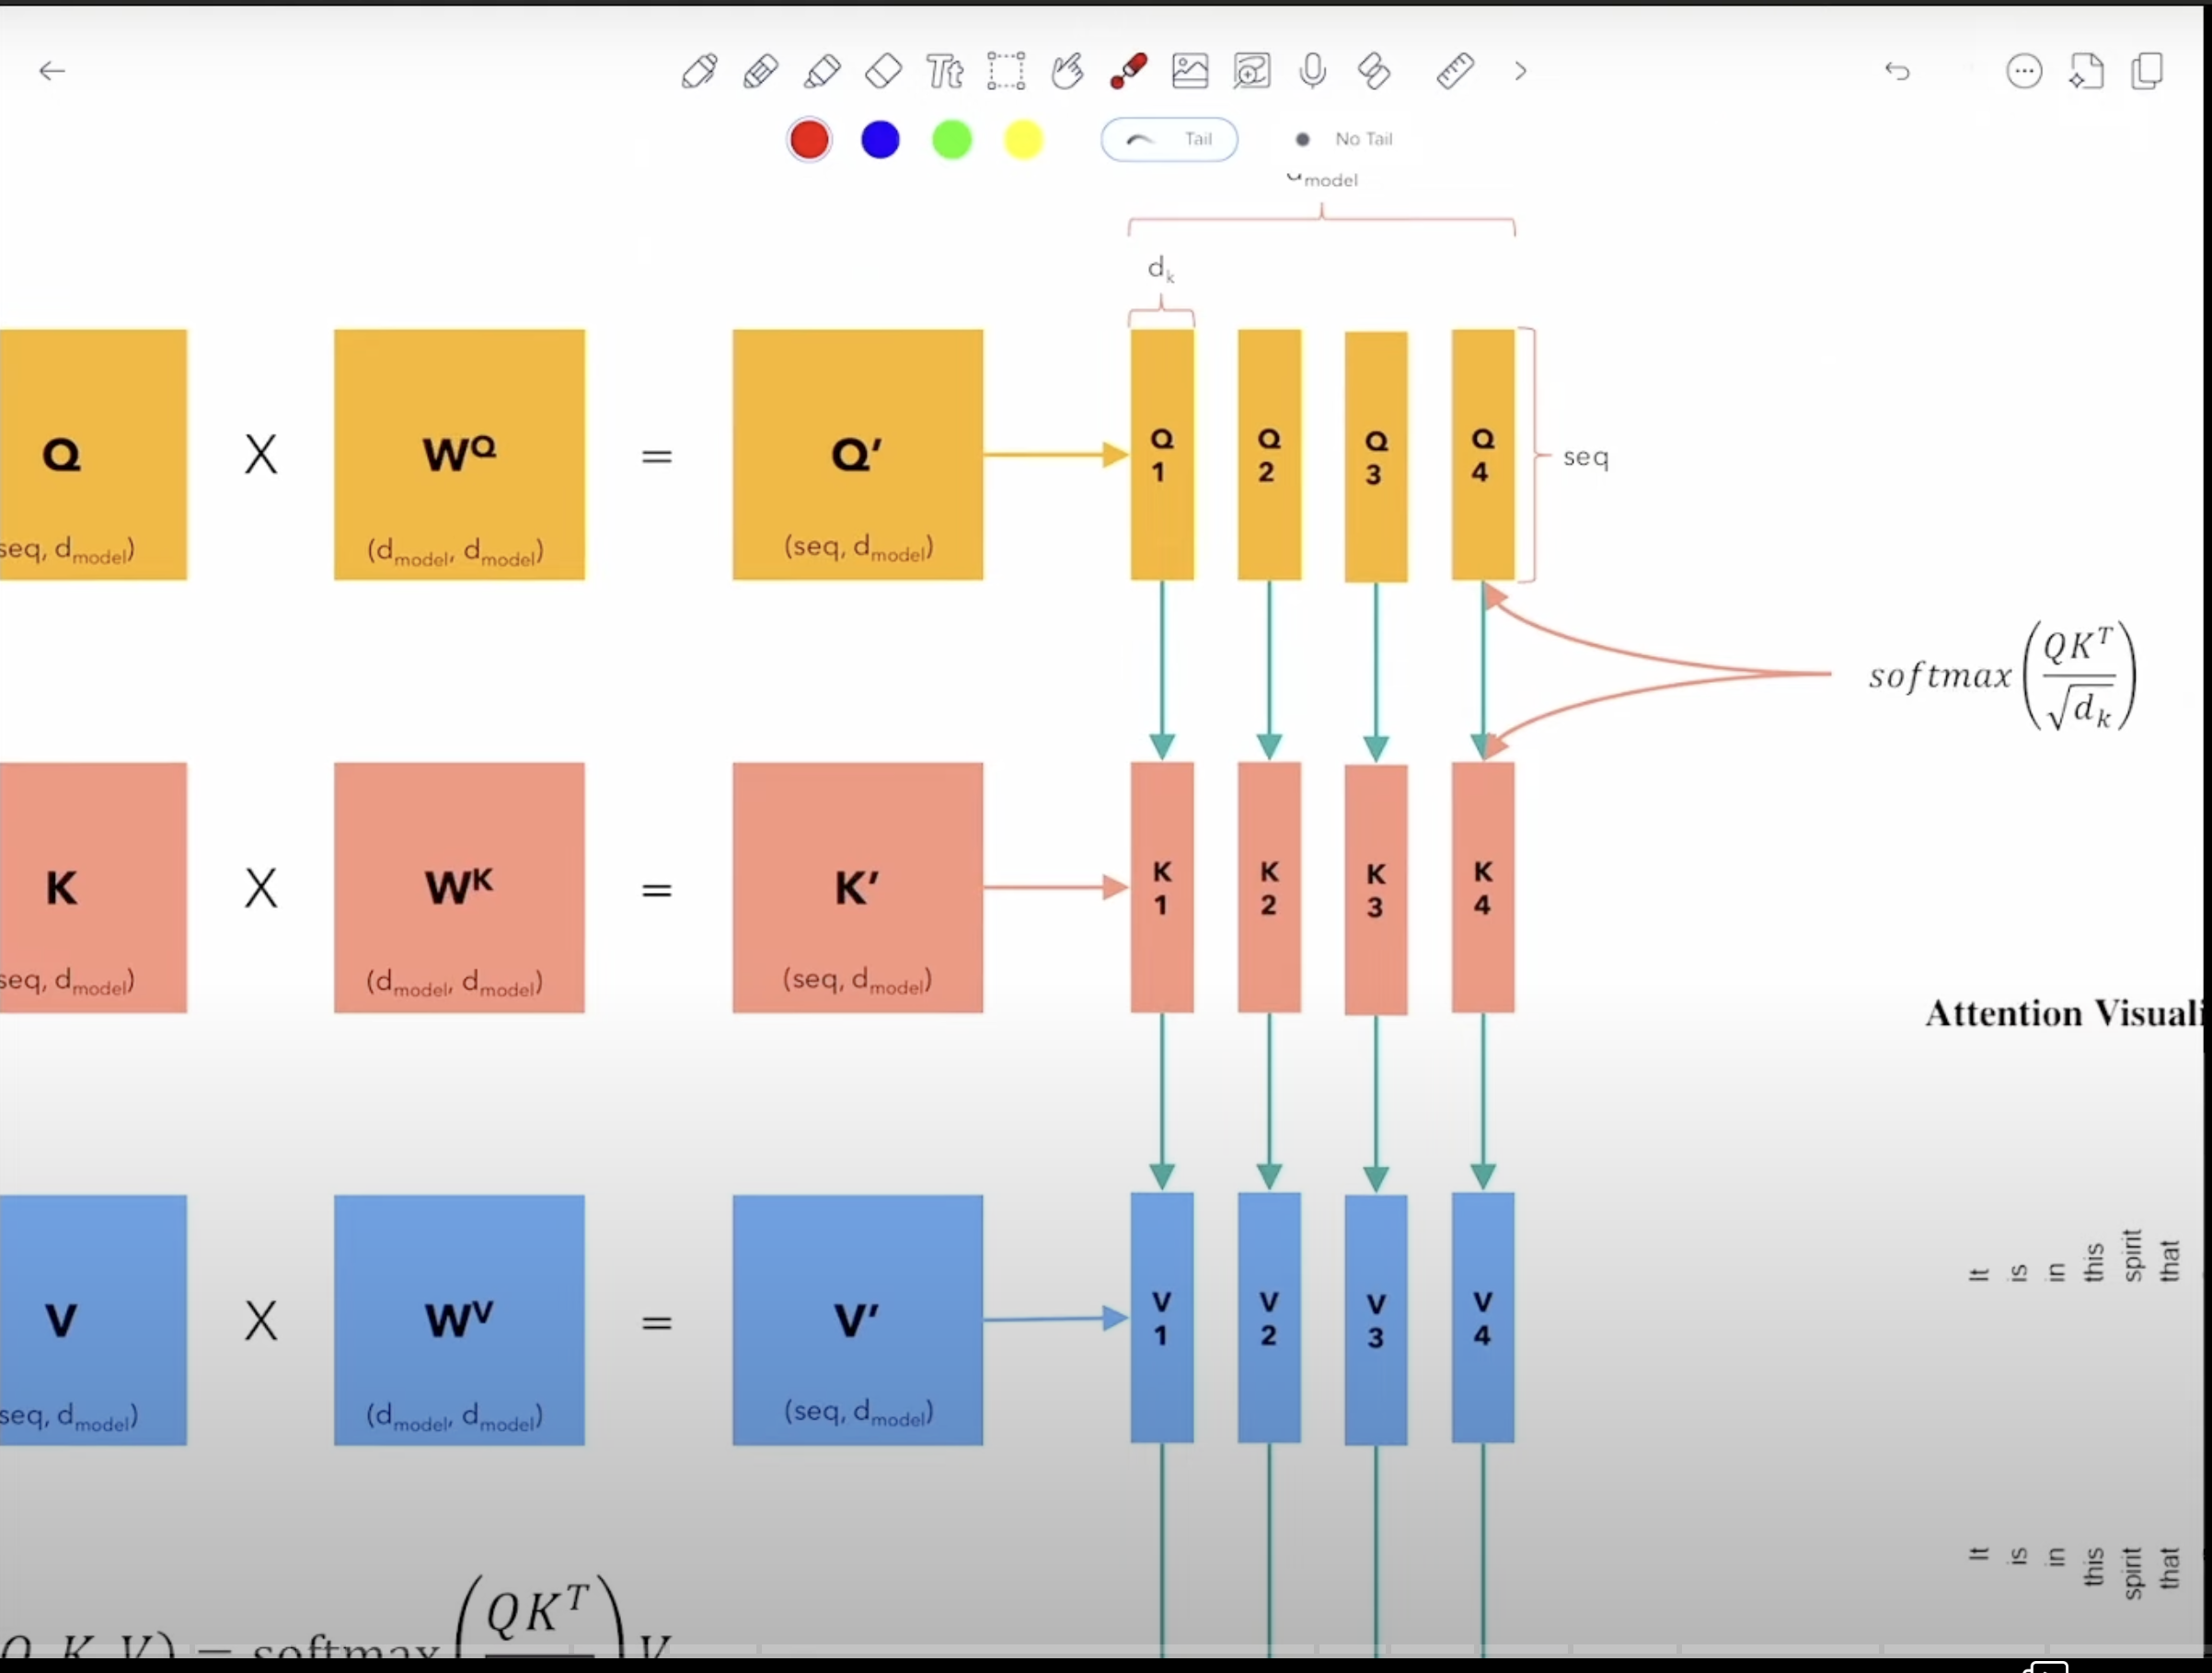

![Screenshot 2025-09-10 at 19.19.54.png](<attachment:Screenshot 2025-09-10 at 19.19.54.png>)
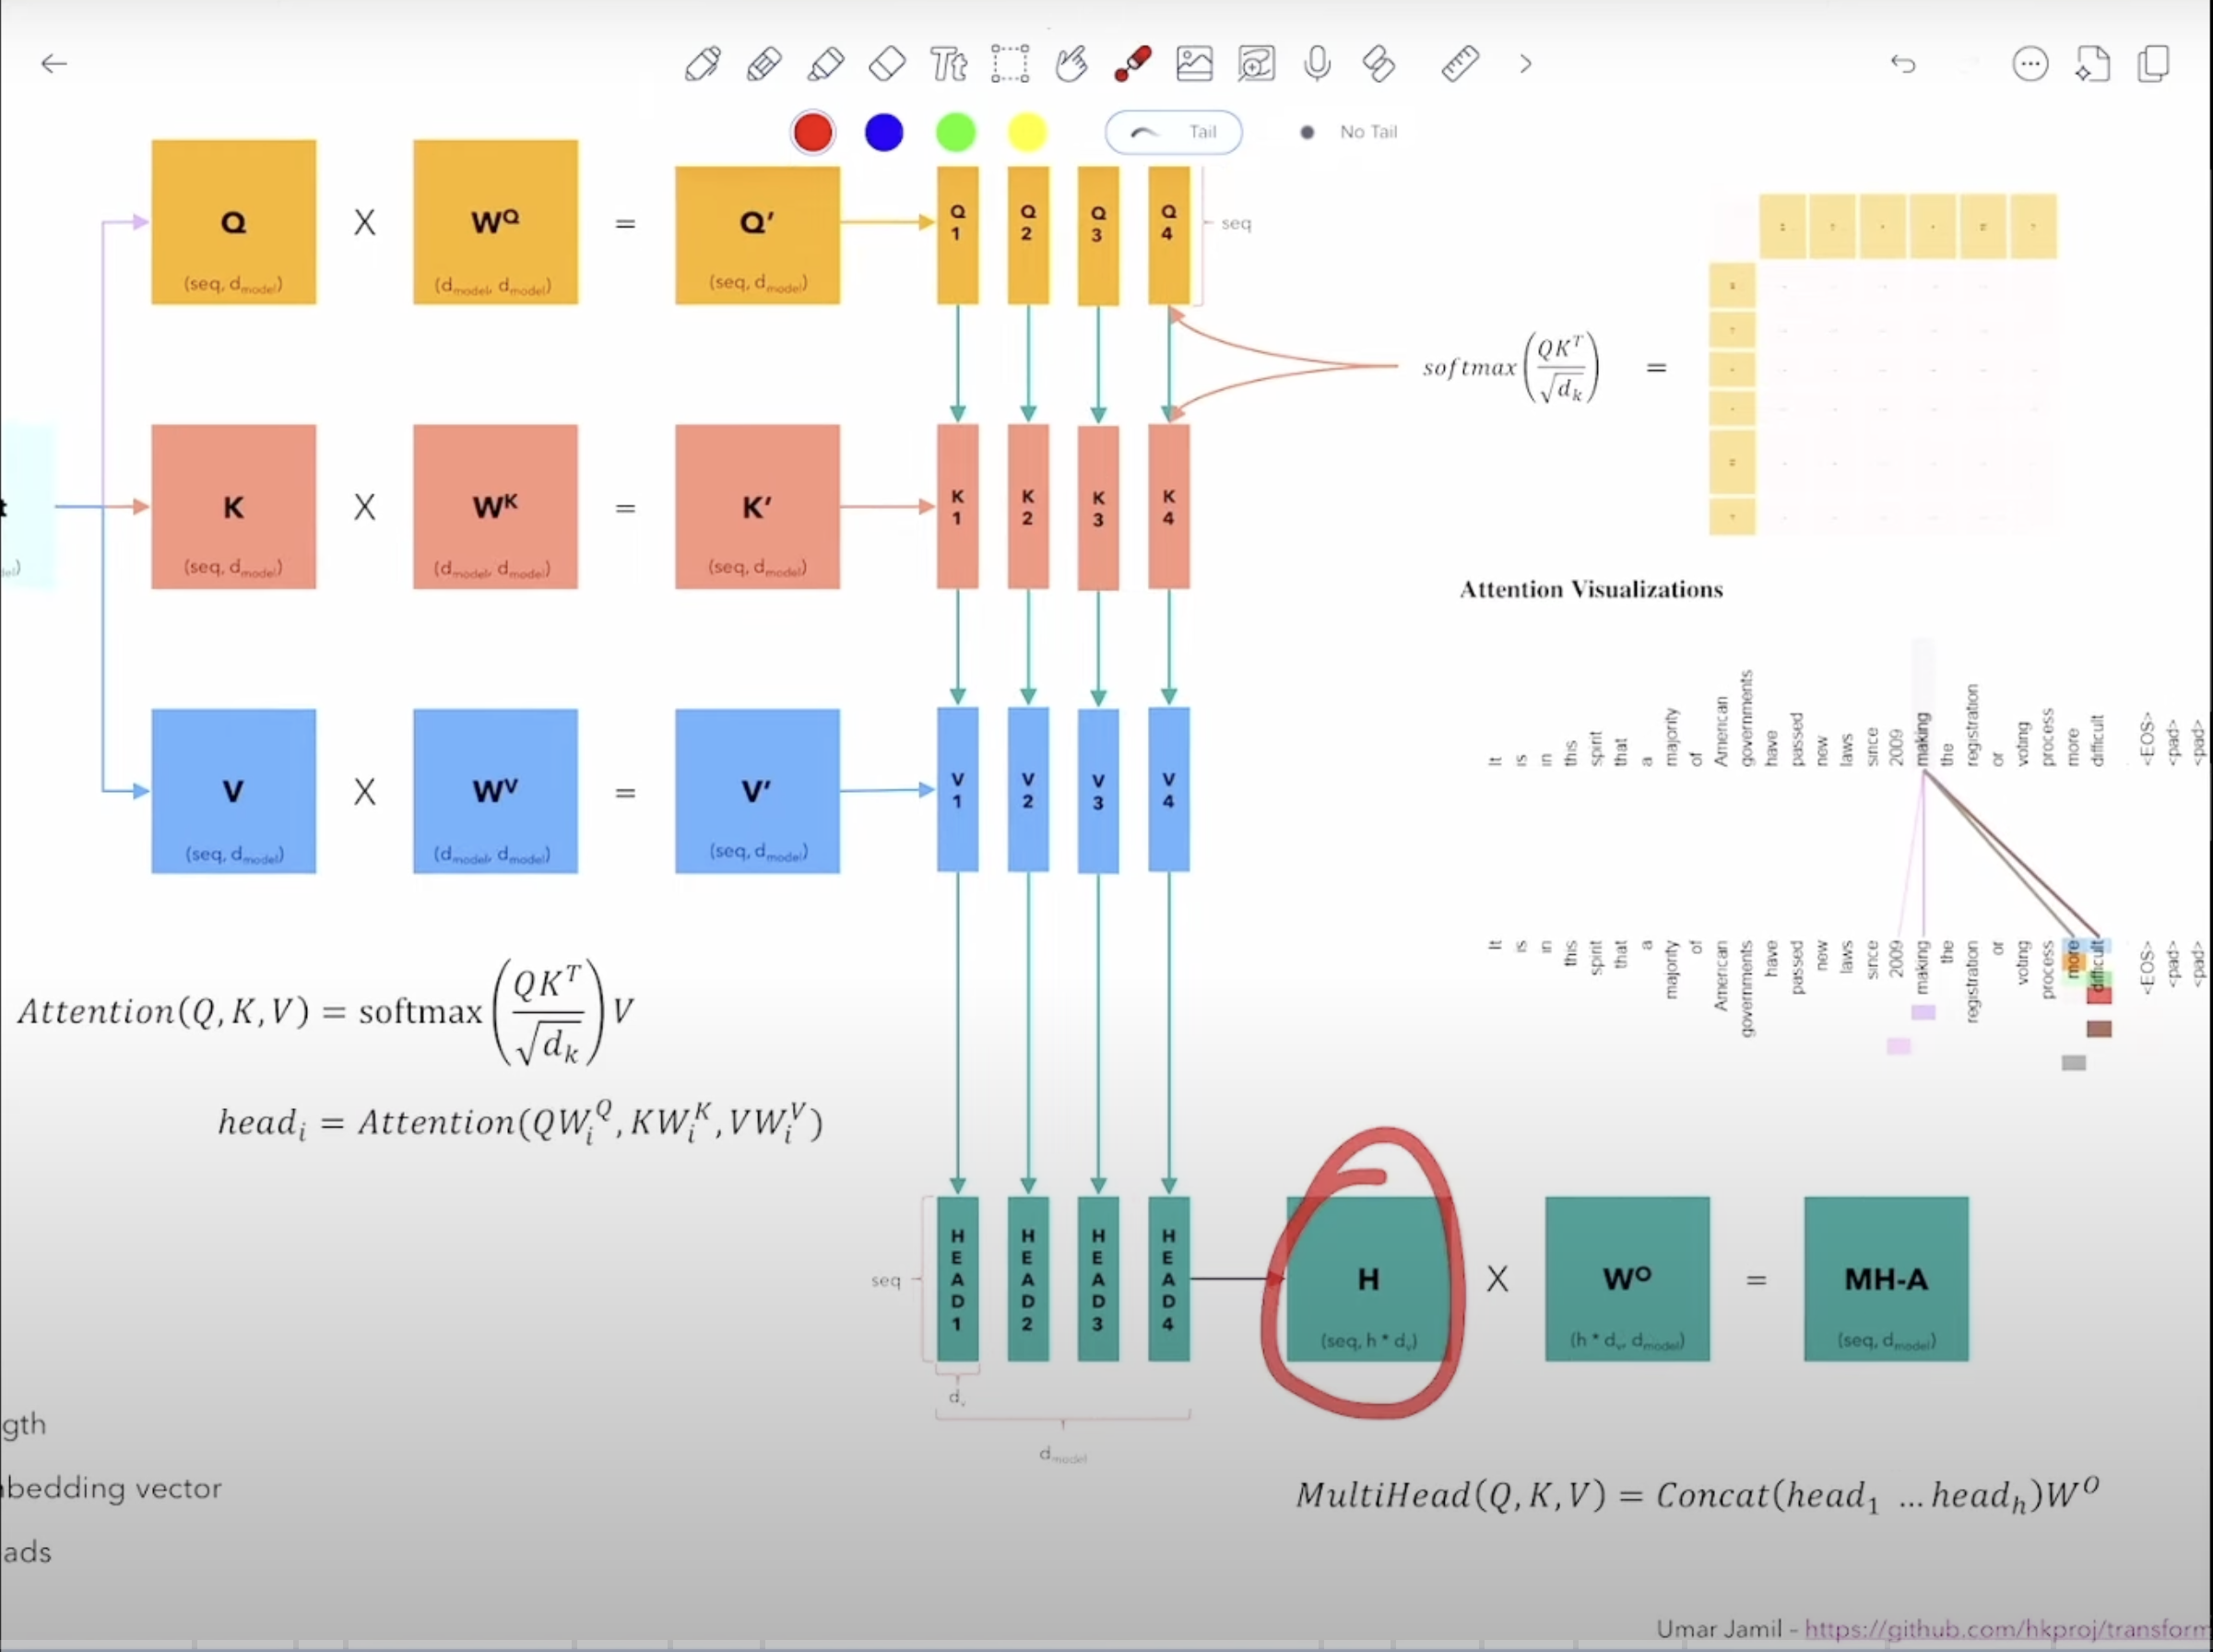

iNice — let’s take this all the way down to the bones. I’ll explain what $QK^\top$ actually is, what each number means, why we divide by $\sqrt{d_k}$, what softmax does, and how the result is used to compute the final outputs. I’ll include a small numeric example so you can see the numbers change step-by-step.

# 1) What is $QK^\top$? (shape and element meaning)

* Suppose
  $Q \in \mathbb{R}^{\text{(seq\_len\_q)}\times d_k}$ and
  $K \in \mathbb{R}^{\text{(seq\_len\_k)}\times d_k}$.
  Then

  $$
  QK^\top \in \mathbb{R}^{\text{(seq\_len\_q)}\times \text{(seq\_len\_k)}}.
  $$

* **Element interpretation:** the entry $(i,j)$ of $S = QK^\top$ is

  $$
  S_{i,j} = Q_i \cdot K_j
  $$

  (the dot product between query vector $Q_i$ and key vector $K_j$).
  So $S_{i,j}$ is a *compatibility score* (how much query token $i$ “matches” key token $j$).

* If you are doing **self-attention** then seq\_len\_q = seq\_len\_k and $S$ is square; for **cross-attention** they can be different lengths and $S$ is rectangular.

# 2) Geometric intuition for the dot product

* $Q_i\cdot K_j = \|Q_i\|\|K_j\|\cos(\theta_{ij})$.
  So it’s large when:

  * the two vectors point in roughly the same direction (high cosine), and/or
  * they have large magnitudes.
* If you normalize vectors (or use small magnitudes), the dot product approximates *cosine similarity*.

# 3) Why divide by $\sqrt{d_k}$?

* If components of $Q$ and $K$ are roughly independent with variance $\sigma^2$, then the variance of the dot product grows roughly like $d_k \sigma^2$. So for larger $d_k$ the raw dot products have larger magnitudes.
* Large magnitudes → softmax outputs become very “peaky” (almost one-hot), which:

  * reduces gradient signal (bad for training), and
  * makes optimization unstable.
* Dividing by $\sqrt{d_k}$ normalizes the scale: it keeps the variance of the logits roughly constant as $d_k$ changes. So we use

  $$
  \text{scores} = \frac{QK^\top}{\sqrt{d_k}}.
  $$

  This is effectively a temperature normalization for the softmax.

# 4) Softmax: turning scores into attention weights

* After scaling we apply softmax **row-wise** (for each query $i$):

  $$
  A_{i,:} = \text{softmax}\!\bigg(\frac{Q_i K^\top}{\sqrt{d_k}}\bigg).
  $$
* Each row $A_{i,:}$ is a probability distribution over the keys: non-negative and sums to 1. So $A_{i,j}$ tells you *what fraction of attention* query $i$ gives to key $j$.

# 5) Using the attention weights

* The final per-query output is the weighted sum of the value vectors $V$:

  $$
  \text{output}_i = \sum_{j} A_{i,j}\, V_j.
  $$

  In matrix form: $\text{Output} = A V$.
  So attention = compute compatibility (QKᵀ) → normalize (softmax) → form weighted sum of values.

# 6) A concrete numeric toy example (step-by-step)

Take a tiny example so you can see numbers:

* Let $d_k=2$.
  $Q = \begin{bmatrix}1&0\\[2pt]0&1\\[2pt]1&1\end{bmatrix},\quad
   K = \begin{bmatrix}1&0\\[2pt]1&1\\[2pt]0&1\end{bmatrix}.$

1. Compute $S=QK^\top$ (3×3):

   $$
   S = \begin{bmatrix}
   1 & 1 & 0\\[2pt]
   0 & 1 & 1\\[2pt]
   1 & 2 & 1
   \end{bmatrix}.
   $$

2. Scale by $\sqrt{d_k}=\sqrt{2}\approx1.4142$:

   $$
   S/\sqrt{d_k} \approx
   \begin{bmatrix}
   0.7071 & 0.7071 & 0.0000\\
   0.0000 & 0.7071 & 0.7071\\
   0.7071 & 1.4142 & 0.7071
   \end{bmatrix}.
   $$

3. Apply softmax row-wise (exponentiate each entry and normalize by the row sum). The attention matrix becomes

   $$
   A \approx
   \begin{bmatrix}
   0.4011 & 0.4011 & 0.1978\\
   0.1978 & 0.4011 & 0.4011\\
   0.2483 & 0.5035 & 0.2483
   \end{bmatrix}.
   $$

   * Interpret row 3: query 3 attends about 50% to key 2 and \~25% to keys 1 and 3.

4. Then multiply by $V$ (whatever your value vectors are) to get outputs — each output is a convex combination of the value vectors.

# 7) Practical details & extra points

* **Masking:** before softmax you can add $-\infty$ (or a very large negative) to positions you want to block (causal masks for masking future tokens, padding masks). That makes their softmax weight ≈ 0.
* **Multi-head:** the same process happens per head with smaller $d_k$ (usually $d_k = d_\text{model}/h$). Each head produces its own attention matrix; head outputs are concatenated and linearly mixed.
* **Alternatives:** additive attention (Bahdanau) uses an MLP instead of dot product. Dot-product attention is fast and parallelizable.
* **Interpretability:** the softmaxed matrix $A$ is often shown as a heatmap — it’s a direct visualization of which tokens each query focuses on.

# 8) Short summary

* $QK^\top$ = matrix of raw compatibility scores (dot products) between queries and keys.
* Divide by $\sqrt{d_k}$ to keep the logits well scaled (prevents softmax saturation).
* Apply softmax row-wise → get attention weights (rows sum to 1).
* Multiply those weights with $V$ → weighted sums = final attended outputs.

If you want, I can:

* show the same worked example with actual $V$ and the final outputs; or
* draw a tiny diagram showing how a single query row picks values — whichever helps you most.


Perfect — let’s do a **full flow with a concrete example** so you see exactly how the numbers propagate from **Q, K, V** → $QK^\top$ → scaling → softmax → final weighted sum.

---

## Example Setup

Let’s keep it tiny:

* Sequence length: **3 tokens**
* Head dimension: $d_k = d_v = 2$

So each token has a 2-dim query/key/value vector.

$$
Q = \begin{bmatrix}
1 & 0 \\ 
0 & 1 \\
1 & 1
\end{bmatrix}, \quad
K = \begin{bmatrix}
1 & 0 \\ 
1 & 1 \\
0 & 1
\end{bmatrix}, \quad
V = \begin{bmatrix}
1 & 0 \\ 
0 & 2 \\
3 & 1
\end{bmatrix}
$$

---

## Step 1 — Compute $QK^\top$

Dot product of every query with every key:

$$
QK^\top =
\begin{bmatrix}
1 & 1 & 0 \\
0 & 1 & 1 \\
1 & 2 & 1
\end{bmatrix}
$$

Shape: $(3,3)$ = queries × keys

* Row 1 = similarity of **query 1** with all keys
* Row 2 = similarity of **query 2** with all keys
* Row 3 = similarity of **query 3** with all keys

---

## Step 2 — Scale by $\sqrt{d_k} = \sqrt{2} \approx 1.414$

$$
S = \frac{QK^\top}{\sqrt{2}} \approx
\begin{bmatrix}
0.71 & 0.71 & 0.00 \\
0.00 & 0.71 & 0.71 \\
0.71 & 1.41 & 0.71
\end{bmatrix}
$$

This keeps scores in a reasonable range.

---

## Step 3 — Softmax row-wise

Apply softmax to each row (normalize across keys):

$$
A \approx
\begin{bmatrix}
0.401 & 0.401 & 0.198 \\
0.198 & 0.401 & 0.401 \\
0.248 & 0.503 & 0.248
\end{bmatrix}
$$

* Row 1: query 1 attends equally to key 1 and 2 (\~40% each), less to key 3 (\~20%).
* Row 2: query 2 splits \~40% on keys 2 & 3, \~20% on key 1.
* Row 3: query 3 focuses strongly on key 2 (\~50%).

---

## Step 4 — Multiply with $V$

Now compute output = $AV$:

$$
\text{Output} = A \times V
$$

Carry out multiplication:

$$
\text{Output} =
\begin{bmatrix}
0.401 & 0.401 & 0.198 \\
0.198 & 0.401 & 0.401 \\
0.248 & 0.503 & 0.248
\end{bmatrix}
\times
\begin{bmatrix}
1 & 0 \\
0 & 2 \\
3 & 1
\end{bmatrix}
$$

$$
\text{Output} \approx
\begin{bmatrix}
0.995 & 1.198 \\
1.401 & 1.604 \\
1.997 & 2.005
\end{bmatrix}
$$

---

## Step 5 — Interpret

* **Token 1 output** ≈ $[0.995, 1.198]$: it blended mostly values from token 1 and 2.
* **Token 2 output** ≈ $[1.401, 1.604]$: a mix of token 2 and 3’s values.
* **Token 3 output** ≈ $[1.997, 2.005]$: heavily influenced by token 2 (since it paid \~50% attention there).

So the **attention mechanism let each token recompute its representation as a weighted mixture of all token values** — with weights determined by query–key similarity.

---

👉 Do you want me to also **draw a mini diagram** (like a heatmap of the attention matrix $A$) so you can *see* how each query spreads its attention across keys?


# Scaled dot product 

Great observation 👍 — let’s get very precise about this:

### 1. Dot Product vs Cosine Similarity

* The raw score in **scaled dot-product attention** is:

  $$
  s_{i,j} = \frac{Q_i \cdot K_j}{\sqrt{d_k}}
  $$
* The **cosine similarity** between $Q_i$ and $K_j$ is:

  $$
  \cos(\theta_{i,j}) = \frac{Q_i \cdot K_j}{\|Q_i\|\|K_j\|}
  $$

So:

* Dot product = similarity **scaled by vector lengths**.
* Cosine similarity = similarity **independent of vector lengths**.

---

### 2. Why not normalize (cosine)?

If we normalized $Q$ and $K$ to unit length, then scaled dot-product attention would basically *be* cosine similarity (up to a constant).
But in Transformers we **don’t normalize them** because:

* Keeping magnitudes lets the model learn to emphasize or de-emphasize tokens via length.
* Scaling by $\sqrt{d_k}$ stabilizes training without throwing away magnitude information.

---

### 3. So what does attention compute?

* It’s not exactly cosine similarity.
* It’s **a learned similarity measure**:

  * If the model wants cosine-like behavior, it can normalize implicitly (by controlling norms of queries/keys through training).
  * But it also has the flexibility to let longer vectors dominate when needed.

---

### 4. Geometric view

* Without normalization: similarity is like **cosine × magnitude factor**.
* After dividing by $\sqrt{d_k}$, we keep the scale roughly stable across dimensions.
* Then **softmax** converts these scores into probabilities → attention weights.

---

✅ **So attention weights are *softmaxed, scaled dot-products*, not pure cosine similarities.**
They *behave like cosine similarity* in spirit (measuring alignment between vectors), but with magnitude information preserved.

---

Do you want me to show you a **numerical side-by-side comparison** (dot product similarity vs cosine similarity) on a tiny Q/K example so you can *see* how they differ?


Yes ✅ — you’ve got the core idea right. Let’s slow it down and phrase it carefully:

---

### 1. What $QK^\top$ does

* $Q$ = queries
* $K$ = keys
* $QK^\top$ = matrix of **similarity scores**

  * Entry $(i,j)$ = dot product between query $i$ and key $j$.
  * Dot product ≈ “how aligned” or “how similar” two vectors are.

So at this stage we have **raw similarity scores**.

---

### 2. Why we scale (divide by $\sqrt{d_k}$)

* If dimension $d_k$ is large, dot products $Q_i \cdot K_j$ can grow large in magnitude.
* Large magnitudes → softmax produces very peaky distributions → unstable training.
* Scaling by $\sqrt{d_k}$ keeps scores in a stable range.

$$
S = \frac{QK^\top}{\sqrt{d_k}}
$$

Now each similarity score is normalized relative to vector dimension.

---

### 3. What happens next

* We apply **softmax row-wise** to turn each row of similarities into **attention weights** (probabilities over keys for each query).
* These weights tell us *how much query token $i$ should attend to each key token $j$*.

---

✅ So in short:

* $QK^\top$ = raw similarity (dot product).
* Divide by $\sqrt{d_k}$ = scale down to keep training stable.
* Softmax = normalize similarities into probabilities.

---

Would you like me to also **contrast this with cosine similarity** (dot product normalized by vector norms) so you see exactly how attention’s notion of “similarity” is a bit different?


# Flash Attentions: optimized way to compute the same scaled dot-product attention formula.

You nailed the intuition 👌 — **FlashAttention** is not a new kind of attention, it’s an **optimized way to compute the same scaled dot-product attention formula**.

Let me break it down step by step:

---

### 1. The attention formula (the “math”)

The standard scaled dot-product attention is:

$$
\text{Attention}(Q, K, V) = \text{softmax}\!\left(\frac{QK^\top}{\sqrt{d_k}}\right) V
$$

That’s the **same** whether you use “normal attention” or FlashAttention.

---

### 2. The bottleneck in practice

When implementing this naively, you need to form $QK^\top$:

* If $Q$ and $K$ have sequence length $n$, then $QK^\top$ is an $n \times n$ matrix.
* For long sequences ($n = 10,000+$), this matrix doesn’t even fit into GPU memory.
* Even worse: softmax requires storing these big intermediate matrices, which wastes bandwidth and slows training.

---

### 3. FlashAttention optimization idea

FlashAttention says:

* Don’t materialize the full $QK^\top$ matrix in memory.
* Instead, compute the **attention scores block by block, on the fly**, and directly apply softmax + weighting with $V$.

So instead of:

1. Compute giant $QK^\top$
2. Apply softmax
3. Multiply with $V$

It does:

* Fused kernels that **stream through Q, K, V** in chunks and compute the final result in one go.

This reduces both:

* **Memory footprint** (doesn’t store all scores),
* **Time** (fewer reads/writes, better GPU utilization).

---

### 4. What FlashAttention is concerned with

✅ Efficient implementation of the *operations inside the formula*:

* dot product $QK^\top$,
* scaling by $\sqrt{d_k}$,
* row-wise softmax,
* multiplying by $V$.

❌ It does **not** change the math of attention. The outputs are **exactly the same** as standard attention (up to floating-point precision).

---

### 5. Summary in one line

FlashAttention = *same attention formula*, but computed in a **GPU-friendly, memory-efficient way**.

---

Do you want me to also give you a **visual breakdown** (like: naive implementation vs FlashAttention block-wise computation) so you can picture what changes under the hood?
